# Kaggle의 가위바위보

데이터 : https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

MyDrive/DLMLJUPYTER/RPS.zip

## #01. 패키지

In [ ]:
import os
import helper_colab
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

## #02. 데이터셋 준비

이미지에 대한 압축 파일을 구글 드라이브에 업로드 해 놓은 상황

### 1. 이미지 파일의 압축 해제

In [ ]:
# 압축 파일 경로
file_path = "/content/drive/MyDrive/DLMLJUPYTER/RPS.zip"

# 압축 해제 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 2. 임의의 이미지 확인

#### 데이터셋 파일 경로 및 각 폴더안에서 임의의 이미지를 추출하여 확인

훈련용 이미지와 검증용 이미지가 따로 구분되어 있지 않다.

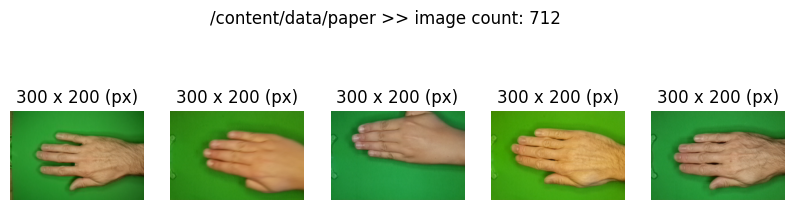

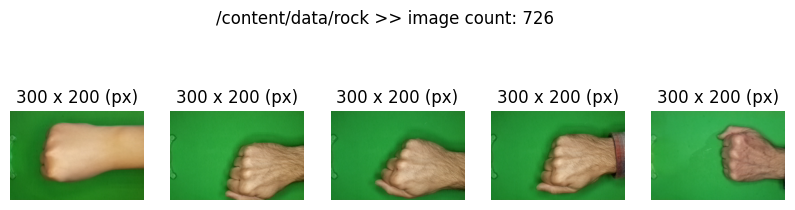

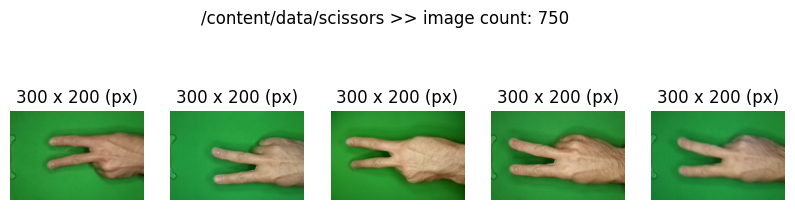

In [ ]:
features = ['paper', 'rock', 'scissors']

for j, w in enumerate(features):
    target_dir = os.path.join(extract_dir, w)
    #print(target_dir)

    file_list = os.listdir(target_dir)
    file_count = len(file_list)

    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.suptitle("%s >> image count: %d" % (target_dir, file_count))

    for k, x in enumerate(ax):
        file_path = os.path.join(target_dir, file_list[k])
        sample = Image.open(file_path)
        x.set_title("%d x %d (px)" % (sample.size[0], sample.size[1]), fontsize=12)
        x.imshow(sample)
        x.axis('off')

    plt.show()
    plt.close()

## #03. 데이터 전처리

### 이미지 데이터 증강

ImageDataGenerator 객체를 생성하면서 `validation_split` 파라미터로 검증용 이미지의 비율을 지정해줄 경우 `flow_from_directory()` 메서드에 훈련용과 검증용으로 분할하기 위해 `subset` 파라미터를 적용할 수 있다.

`ImageDataGenerator`는 훈련용 이미지가 저장되어 있는 폴더, 검증용 이미지가 저장되어 있는 폴더까지만 전달한다.

`ImageDataGenerator`가 하위 폴더를 식별하여 그 안의 항목들을 읽어들인다.

> https://keras.io/ko/preprocessing/image/

> batch_size가 클 수록 학습 속도는 빨라지지만 정확도는 하락.

| 파라미터 | 설명 |
|---|---|
| rescale | 색상에 대한 정규화 처리 |
| rotation_range | 지정된 각도 범위내에서 임의로 원본 이미지를 회전 시킴 |
| width_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수평 이동 시킴 |
| height_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수직 이동 시킴 |
| vertical_flip | `True`인 경우 이미지를 수직 반전 시킴 |
| horizontal_flip | `True`인 경우 이미지를 수평 반전 시킴 |
| validation_split | 훈련용, 검증용을 분할하고자 할 경우 검증용의 비율을 지정 |

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,   #일반화
                                    # rotation_range = 90,
                                    # width_shift_range=0.4,
                                    # height_shift_range=0.4,
                                    # vertical_flip =True,
                                    # horizontal_flip =True,
                                   validation_split=0.3 )

# 이미지를 100x100으로 리사이즈
train_set = train_datagen.flow_from_directory(extract_dir, classes=['paper', 'rock', 'scissors'],
                                              batch_size=5, # 이미지를 증강시킬 배수
                                              class_mode='categorical', # 다중분류용임을 명시
                                              target_size=(100, 100),   # 변환될 이미지 해상도(크기)
                                              subset="training")    #훈련용과 검증용으로 분할하기 위해 `subset` 파라미터를 적용

test_set = train_datagen.flow_from_directory(extract_dir, classes=['paper', 'rock', 'scissors'],
                                             batch_size=5, class_mode='categorical',
                                             target_size=(100, 100),
                                             subset="validation")

len(train_set), len(test_set)

Found 1533 images belonging to 3 classes.
Found 655 images belonging to 3 classes.


(307, 131)

## #04. 모델 개발

### 모델 정의

(`Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]`)의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기
- **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.
- **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.


 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

> activation : 다중분류 = softmax, unit 10 / 이진 = sigmoid, unit 1/0

> loss : 다중분류 = categorical_crossentropy, 이진 = binary_crossentropy

In [ ]:
model = Sequential()

# ------------------------#
# 1차
# ------------------------#
model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(100, 100, 3))) #컬러 이미지는 3차원
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# ------------------------#
# 2차
# ------------------------#
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# ------------------------#
# 3차
# ------------------------#
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))   #가위바위보 3개

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      1216      
                                                                 
 batch_normalization_2 (Bat  (None, 100, 100, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 batch_normalization_3 (Bat  (None, 50, 50, 32)       

### 학습하기

In [ ]:
# start = dt.datetime.now()

# result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
#     EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
#     ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
# ])

# end = dt.datetime.now()

# delta = end - start

# "총 학습 소요 시간: %d(초)" % delta.seconds

%%time
result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
307/307 [==============================] - 12s 26ms/step - loss: 1.8506 - acc: 0.7417 - val_loss: 3.3080 - val_acc: 0.3924 - lr: 0.0010
Epoch 2/500
307/307 [==============================] - 8s 26ms/step - loss: 0.3086 - acc: 0.9159 - val_loss: 0.2465 - val_acc: 0.9206 - lr: 0.0010
Epoch 3/500
307/307 [==============================] - 6s 20ms/step - loss: 0.4400 - acc: 0.9191 - val_loss: 1.0944 - val_acc: 0.8947 - lr: 0.0010
Epoch 4/500
307/307 [==============================] - 8s 25ms/step - loss: 0.3222 - acc: 0.9524 - val_loss: 0.2922 - val_acc: 0.9267 - lr: 0.0010
Epoch 5/500
307/307 [==============================] - ETA: 0s - loss: 0.2426 - acc: 0.9648
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
307/307 [==============================] - 7s 22ms/step - loss: 0.2426 - acc: 0.9648 - val_loss: 0.2532 - val_acc: 0.9450 - lr: 0.0010
Epoch 6/500
307/307 [==============================] - 8s 27ms/step - loss: 0.0445 - acc: 0.9896 - val_loss:

## #05. 학습 결과 평가

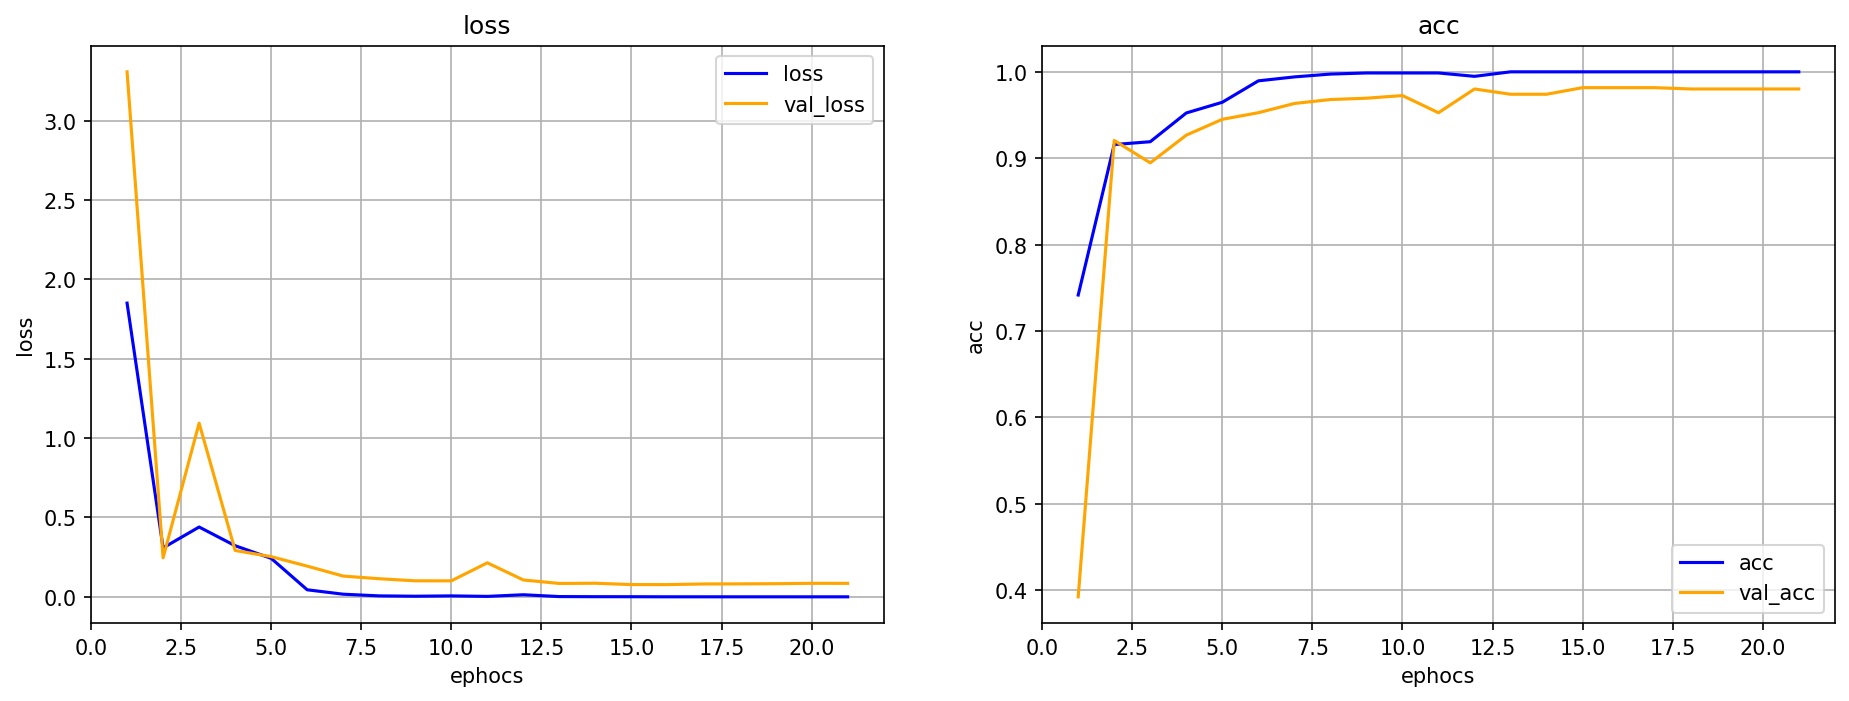

307/307 [==============================] - 4s 14ms/step - loss: 1.3322e-04 - acc: 1.0000
최종 훈련 손실률: 0.000133, 최종 훈련 정확도: 1.000000
131/131 [==============================] - 3s 20ms/step - loss: 0.0850 - acc: 0.9802
최종 검증 손실률: 0.085025, 최종 검증 정확도: 0.980153


In [ ]:
helper_colab.tf_result_plot(result)

evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #06. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과를 산정

In [ ]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred[0]

307/307 [==============================] - 4s 13ms/step
1533개의 검증 데이터가 3개의 경우의 수를 갖는다.


array([9.9999678e-01, 2.9607709e-06, 2.4113874e-07], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [ ]:
pred_result = np.argmax(pred, axis=-1)
pred_result

array([0, 1, 2, ..., 0, 1, 1])

In [ ]:
# 각 종속변수별로 레이블링이 어떻게 되어 있는 확인
train_set.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

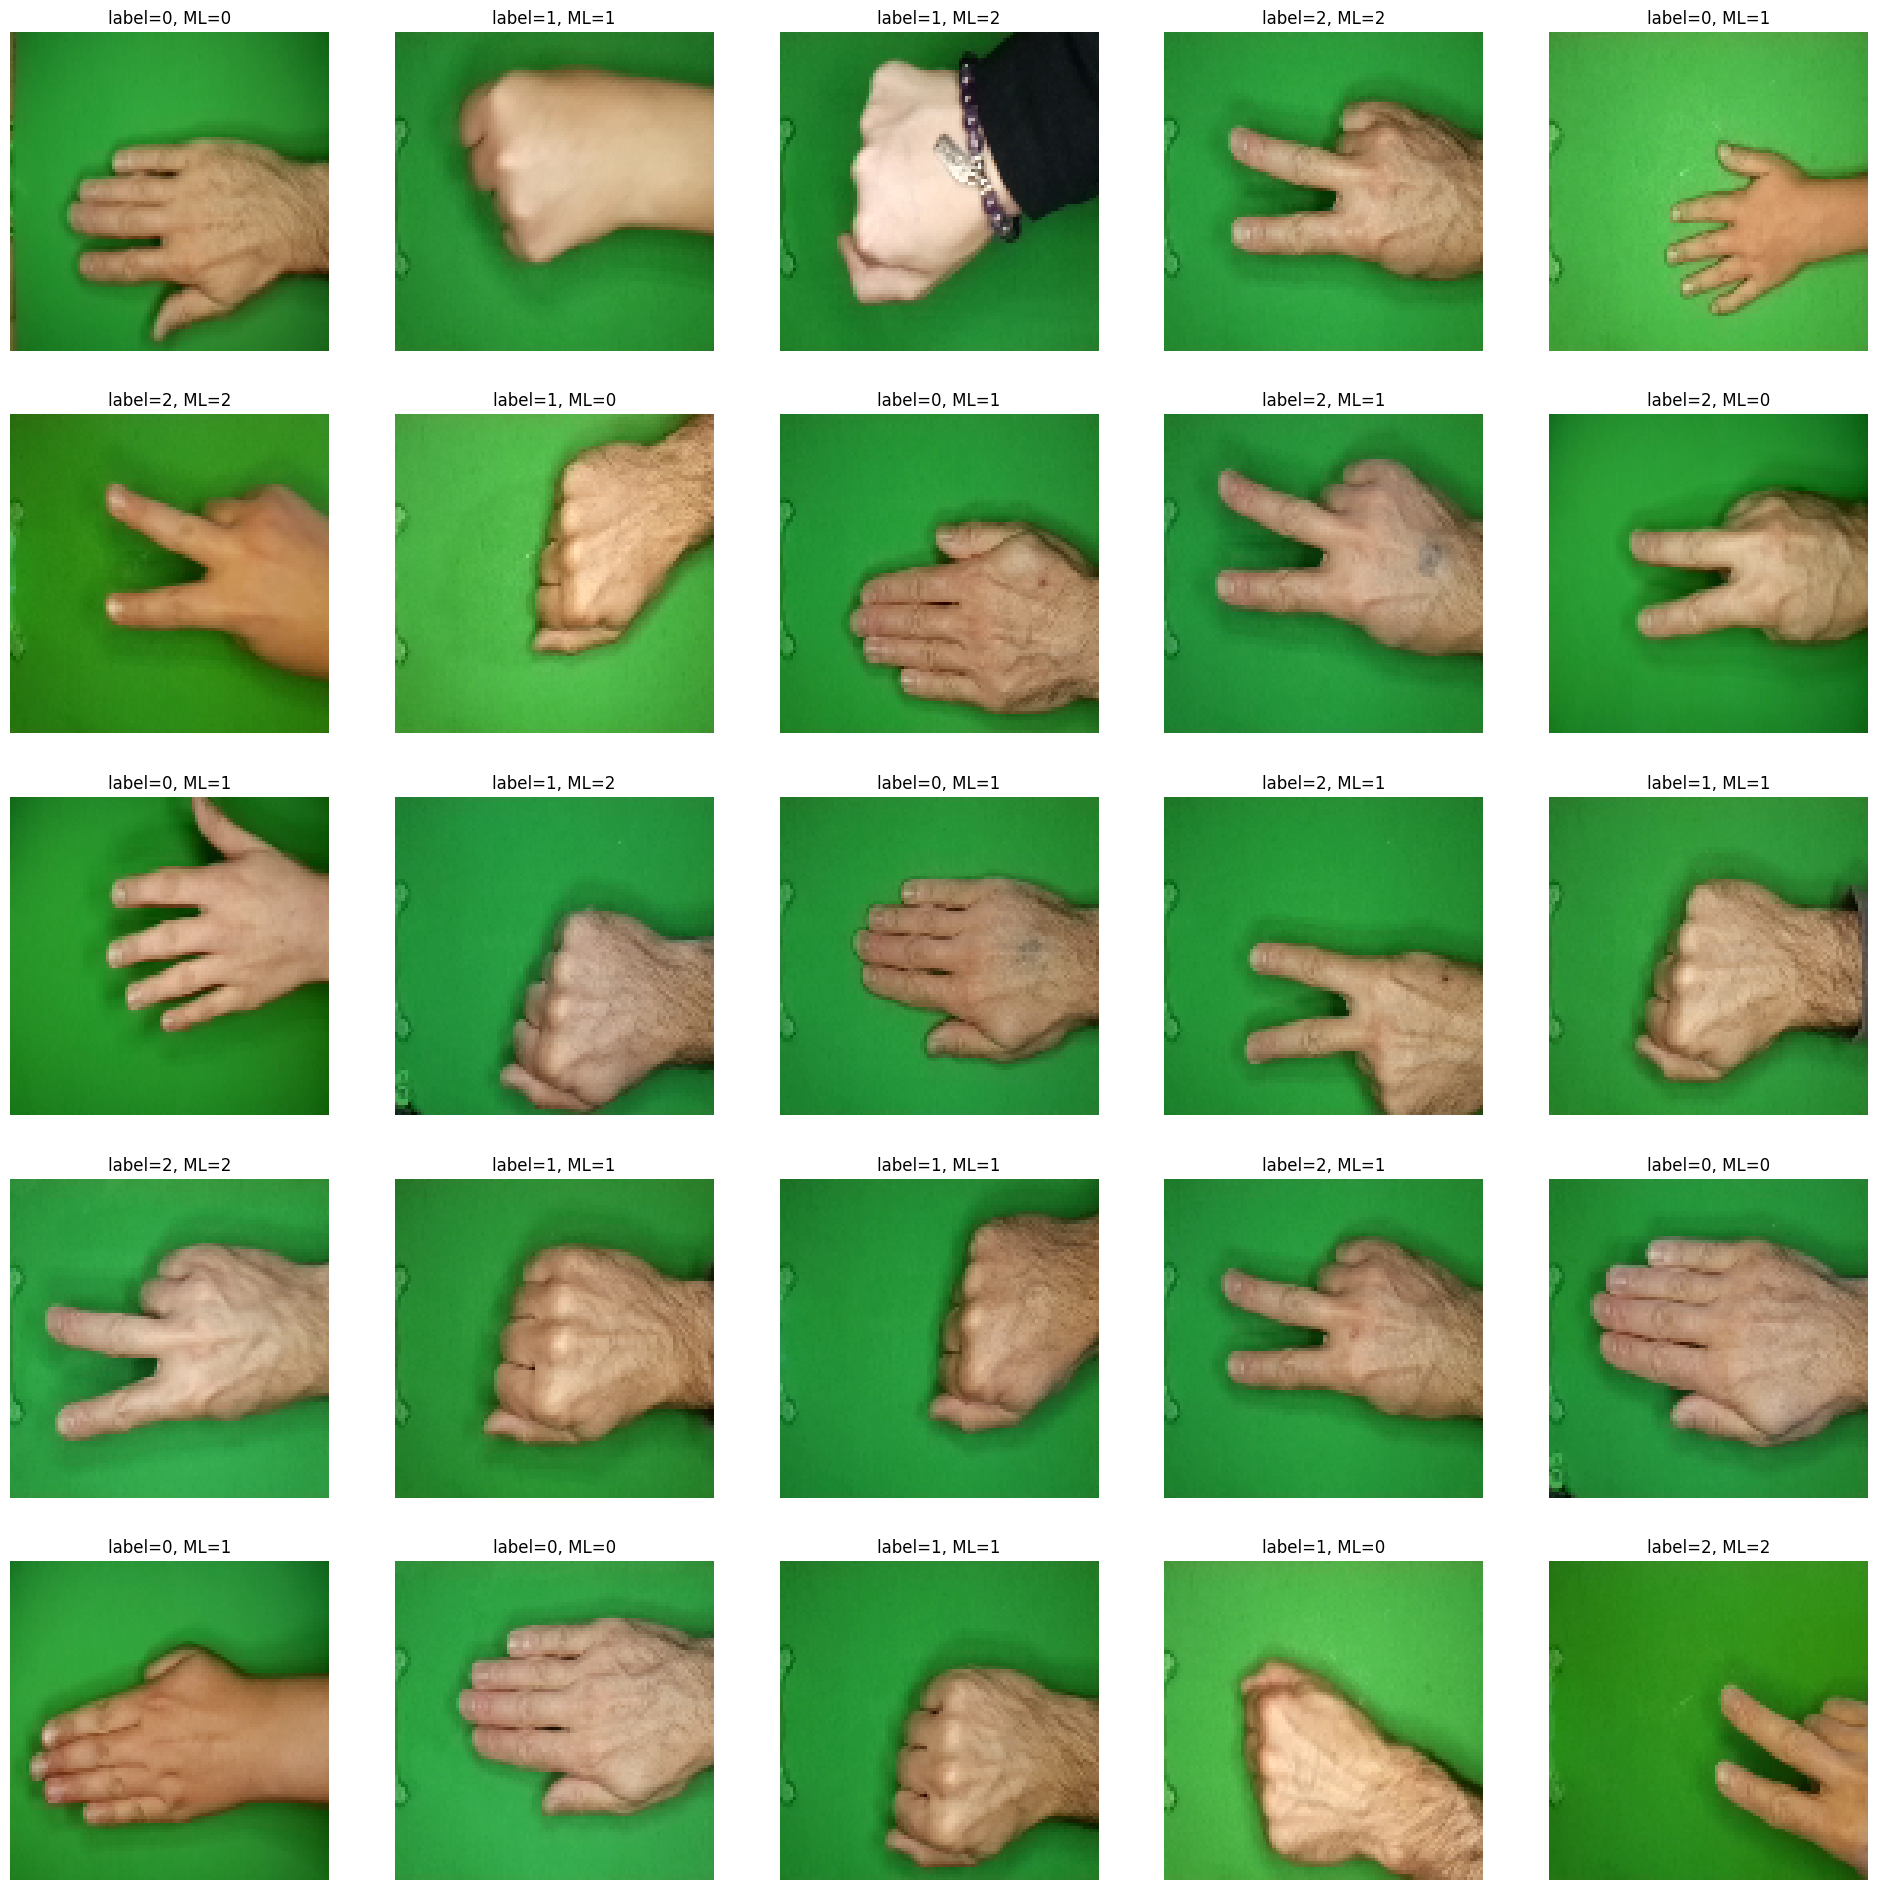

In [ ]:
row = 5                     # 내가 몇 줄을 출력하고 싶은지 지정
col = train_set.batch_size  # batch-size에 맞춰서 지정 (값이 너무 클 경우 반복문 로직을 따로 적용)
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

k = 0

for i in range(0, row):
    # batch_size 만큼의 첫 번째 이미지 묶음을 반환
    # -> img와 label의 길이는 col과 동일하다.
    img, label = train_set.next()

    for j in range(0, col):
        # 종속변수인 label은 one-hot-encoding 형태로 반환되므로 몇 번째 인덱스가 `1`인지 찾아야 한다.
        label_max = np.argmax(label[j], axis=-1)

        ax[i][j].imshow(img[j])
        ax[i][j].set_title("label=%d, ML=%d" % (label_max, pred_result[k]))
        ax[i][j].axis('off')
        k += 1

plt.show()
plt.close()